In [1]:
import numpy as np
import torch
import torch.nn as nn                     # neural networks\
import torch.nn.functional as F
import math


#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


#### Transport equation in segregation direction, assuming imcompressible flow
$$ \frac{\partial c_i}{\partial t} +\frac{\partial ({w_{seg,i} c_i)}}{\partial z} = \frac{\partial }{\partial z} ( D \frac{\partial c_i }{\partial z} ) $$

Segregation velocity model:
$$ w_{seg,i} = 0.26 \ln R_d \dot \gamma (1-c_i)$$


Diffusion coefficient:
$$ D = 0.042 \dot\gamma (c_ld_l + c_s d_s)^2$$

<!-- $$ D = 0.0084 (1+c_l)$$ -->

<!-- So final pde becomes:
$$ \frac{\partial c_i}{\partial t} +\frac{\partial ({18.2 (1-c_i) c_i)}}{\partial z} = \frac{\partial }{\partial z} ( 0.0084 (1+c_l) \frac{\partial c_i }{\partial z} ) $$

$$ \frac{\partial c_i}{\partial t} +  (18.2 -36.4 c_i)\frac{\partial c_i}{\partial z} =  0.0084(1+c_i) \frac{\partial ^2 c_i}{\partial z^2} + 0.0084 (\frac{\partial  c_i}{\partial z})^2$$ -->

#### 

In [8]:
class Net(nn.Module):
    def __init__(self):

        # 6 layer neural network

        super(Net, self).__init__()
        self.dim=200
        self.ln1 = nn.LayerNorm(self.dim)
        self.ln2 = nn.LayerNorm(self.dim)
        self.ln3 = nn.LayerNorm(self.dim)
        self.ln4 = nn.LayerNorm(self.dim)

        self.hidden_layer1 = nn.Linear(1,self.dim)
        self.hidden_layer2 = nn.Linear(self.dim,self.dim)
        self.hidden_layer3 = nn.Linear(self.dim,self.dim)
        self.hidden_layer4 = nn.Linear(self.dim,self.dim)
        self.hidden_layer5 = nn.Linear(self.dim,self.dim)
        self.output_layer = nn.Linear(self.dim,1)
        self.mse=torch.nn.MSELoss()
        
        # particle properties in S.I unit
        self.rd=2
        self.dl=0.004
        self.rho=1000
        self.c_diffusion=0.042
        self.ds=self.dl/self.rd
        self.rds=1/self.rd
        self.ml=4/3*math.pi*0.002**3*self.rho
        self.ms=4/3*math.pi*0.001**3*self.rho
        
        
        # flow configuration (uniform shear)
        self.gamma=100
        self.phi=0.55
        self.g=9.81
        self.h0=0.01
        self.p0=self.h0*self.rho*self.g*self.phi

        # segregation force calculation
        self.theta=torch.tensor(np.cos(0), dtype=torch.float32, requires_grad=True).to(device)  
        #  Duan et al. 2024
        _intruder_l=(1-1.43*np.exp(-self.rd/0.92))*(1+3.55*np.exp(-self.rd/2.94))*self.phi
        _intruder_s=(1-1.43*np.exp(-self.rds/0.92))*(1+3.55*np.exp(-self.rds/2.94))*self.phi


        _intruder_l_exp=0.19*np.tanh( (self.rd-1)/0.59 ) * ( 1+3.63*np.exp(-self.rd/5.48) )
        _intruder_s_exp=0.19*np.tanh( (self.rds-1)/0.59 ) * ( 1+3.63*np.exp(-self.rds/5.48) )


        self.intruder_l_linear=torch.tensor(_intruder_l, dtype=torch.float32, requires_grad=True).to(device) 
        self.intruder_s_linear=torch.tensor(_intruder_s, dtype=torch.float32, requires_grad=True).to(device) 


        self.intruder_l_exp=torch.tensor(_intruder_l_exp, dtype=torch.float32, requires_grad=True).to(device) 
        self.intruder_s_exp=torch.tensor(_intruder_s_exp, dtype=torch.float32, requires_grad=True).to(device) 

        

    def forward(self, z):
        # if time dimensino is considered, concatenated first, i.e. torch.cat([z,t],axis=1) 
        layer1_out = self.ln1(torch.sigmoid(self.hidden_layer1(z)))
        layer2_out = self.ln2(torch.sigmoid(self.hidden_layer2(layer1_out)))
        layer3_out = self.ln3(torch.sigmoid(self.hidden_layer3(layer2_out)))
        layer4_out = self.ln4(torch.sigmoid(self.hidden_layer4(layer3_out)))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output
    

    def range_loss(self,input_variable, min_value, max_value):
        """
        Custom loss function to penalize values outside a certain range.
        Parameters:
            input_variable: The input variable tensor.
            min_value: The minimum value of the range.
            max_value: The maximum value of the range.
        Returns:
            The loss value.
        """
        # Clamp the input variable to the specified range
        clamped_input = torch.clamp(input_variable, min_value, max_value)
        
        # Compute the mean squared error (MSE) between the clamped input and the original input
        loss = self.mse(input_variable, clamped_input)
        
        return loss
    
    def loss(self):


        # PDE loss    
        z_collocation = np.random.uniform(low=0.0, high=0.1, size=(10001,1))

        z = torch.tensor(z_collocation, dtype=torch.float32, requires_grad=True).to(device) 

        exp_factor=(self.h0+z)/0.1*2.3

        c = self(z) 
        
        p=self.rho*self.phi*self.g*z+self.p0
        inert=self.gamma*(c*0.004+(1-c)*(0.004/self.rd))/torch.sqrt(p/self.rho);
        mu_eff=0.364+(0.772-0.364)/(0.434/inert+1)
        eta=mu_eff*p/self.gamma


        self.intruder_l=self.intruder_l_linear+self.intruder_l_exp
        self.intruder_s=self.intruder_s_linear+self.intruder_s_exp

        mixture_l=(self.intruder_l-self.theta)*torch.tanh((self.theta-self.intruder_s)/(self.intruder_l-self.theta)*self.ml/self.ms*(1-c)/(c+1e-16))
        mixture_s=-(self.intruder_l-self.theta)*c/(1-c)*self.ms/self.ml*torch.tanh((self.theta-self.intruder_s)/(self.intruder_l-self.theta)*self.ml/self.ms*(1-c)/(c+1e-16))
        

        cd=(2-7*math.exp(-2.6*self.rd))+0.57*inert*self.rd

        wseg=mixture_l*self.ml*self.g / (cd*math.pi*eta*0.004)

        c_z = torch.autograd.grad(c.sum(), z, create_graph=True)[0]
        
        # Duan et al. 2024  
        pde=(wseg*c-0.042*self.gamma*torch.square((1-c)*self.ds+c*self.dl)*c_z)*100

        # Schlick et al. 2015
        # simplified with constant diffusion coefficient
        # pde = (1/0.1 *(1-c)*c - c_z )*10

        target = torch.zeros_like(pde,requires_grad=False)
        pde_loss=self.mse(pde,target)


        # Mass conservation loss
        x_bc = torch.linspace(0, 0.1, 10001,requires_grad=True).to(device)
        x_bc = x_bc.unsqueeze(-1)
        _u_bc = self(x_bc)
        u_bc=torch.mean(_u_bc)
        
        target=torch.zeros_like(u_bc,requires_grad=False).to(device)+0.5
        mass_loss=self.mse(u_bc,target)
   
        return mass_loss  + pde_loss +  self.range_loss(_u_bc,0,1)
    #torch.max(  10*(torch.min(torch.zeros_like(_u_bc),_u_bc))**2   )

In [9]:
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error


In [11]:
optimizer = torch.optim.Adam(net.parameters(),lr=0.00001)
### (3) Training / Fitting
iterations = 5000
# previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    loss=net.loss()
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    if loss.data<1e-8:
        break
    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)
    
        

0 Traning Loss: tensor(1.1323e-05, device='cuda:0')
1 Traning Loss: tensor(7.5200e-05, device='cuda:0')
2 Traning Loss: tensor(1.3358e-05, device='cuda:0')
3 Traning Loss: tensor(2.0538e-05, device='cuda:0')
4 Traning Loss: tensor(4.2339e-05, device='cuda:0')
5 Traning Loss: tensor(2.5611e-05, device='cuda:0')
6 Traning Loss: tensor(7.0208e-06, device='cuda:0')
7 Traning Loss: tensor(1.1406e-05, device='cuda:0')
8 Traning Loss: tensor(2.4223e-05, device='cuda:0')
9 Traning Loss: tensor(2.3930e-05, device='cuda:0')
10 Traning Loss: tensor(1.2664e-05, device='cuda:0')
11 Traning Loss: tensor(5.8802e-06, device='cuda:0')
12 Traning Loss: tensor(9.0929e-06, device='cuda:0')
13 Traning Loss: tensor(1.5609e-05, device='cuda:0')
14 Traning Loss: tensor(1.5384e-05, device='cuda:0')
15 Traning Loss: tensor(9.6081e-06, device='cuda:0')
16 Traning Loss: tensor(5.2628e-06, device='cuda:0')
17 Traning Loss: tensor(7.0925e-06, device='cuda:0')
18 Traning Loss: tensor(1.1189e-05, device='cuda:0')
19 

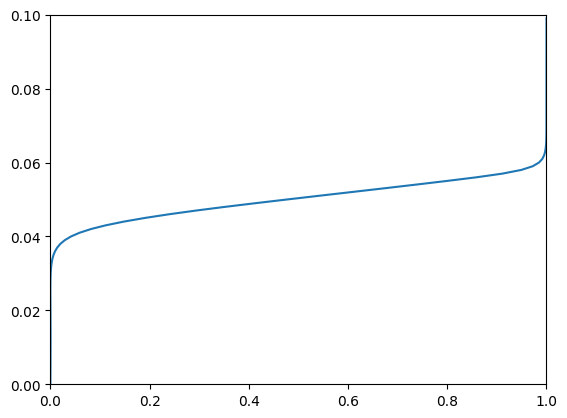

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d') 
net.eval()
x=np.arange(0,0.1,0.001)[:,np.newaxis]
pt_x = torch.tensor(x, dtype=torch.float32, requires_grad=False).to(device).detach()
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()



plt.plot(u,x)
plt.xlim(0, 1) 
plt.ylim(0, 0.1) 
plt.show()

In [ ]:
# Load arrays from the .npz file
loaded_data = np.load('solver_lam.npz')
lam01 = loaded_data['lam01']
lam10 = loaded_data['lam10']
lam10 = loaded_data['lam003']

In [ ]:
# np.savez('solver_lam.npz', lam01=lam01,lam10=lam10,lam003=u)

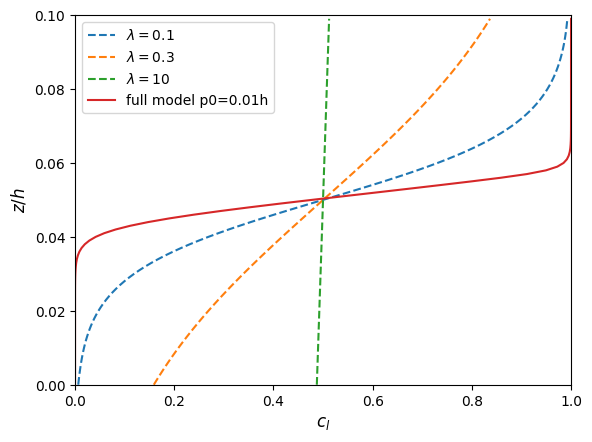

In [ ]:
# for i in loaded_data.values():
    
plt.plot(loaded_data['lam01'],x,linestyle='--',label="$\lambda=0.1$")
plt.plot(loaded_data['lam003'],x,linestyle='--',label="$\lambda=0.3$")
plt.plot(loaded_data['lam10'],x,linestyle='--',label="$\lambda=10$")
plt.plot(u,x,label="full model p0=0.01h")
plt.xlim(0, 1) 
plt.ylim(0, 0.1) 
plt.xlabel('${c_l}$', fontsize=12)
plt.ylabel('$z/h$', fontsize=12)
plt.legend()
plt.savefig('comparison.png')
plt.show()


In [ ]:
u

array([[3.2484531e-06],
       [2.2500753e-06],
       [1.5944242e-06],
       [1.2814999e-06],
       [1.2516975e-06],
       [1.6093254e-06],
       [2.1755695e-06],
       [2.9057264e-06],
       [3.8295984e-06],
       [4.8130751e-06],
       [5.9306622e-06],
       [6.9141388e-06],
       [7.8082085e-06],
       [8.5234642e-06],
       [8.8959932e-06],
       [8.9555979e-06],
       [8.4936619e-06],
       [7.6591969e-06],
       [6.3478947e-06],
       [4.8726797e-06],
       [3.3676624e-06],
       [2.4586916e-06],
       [3.0696392e-06],
       [6.7502260e-06],
       [1.5690923e-05],
       [3.3706427e-05],
       [6.6280365e-05],
       [1.2192130e-04],
       [2.1381676e-04],
       [3.6184490e-04],
       [5.9638917e-04],
       [9.6361339e-04],
       [1.5334487e-03],
       [2.4099648e-03],
       [3.7474036e-03],
       [5.7679415e-03],
       [8.7841302e-03],
       [1.3224006e-02],
       [1.9653559e-02],
       [2.8794378e-02],
       [4.1529745e-02],
       [5.886091